# <a title="Activity Recognition" href="https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition" > LSTMs for Human Activity Recognition</a>

Human Activity Recognition (HAR) using smartphones dataset and an LSTM RNN. Classifying the type of movement amongst six categories:
- WALKING,
- WALKING_UPSTAIRS,
- WALKING_DOWNSTAIRS,
- SITTING,
- STANDING,
- LAYING.

Compared to a classical approach, using a Recurrent Neural Networks (RNN) with Long Short-Term Memory cells (LSTMs) require no or almost no feature engineering. Data can be fed directly into the neural network who acts like a black box, modeling the problem correctly. [Other research](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names) on the activity recognition dataset can use a big amount of feature engineering, which is rather a signal processing approach combined with classical data science techniques. The approach here is rather very simple in terms of how much was the data preprocessed. 

Let's use Google's neat Deep Learning library, TensorFlow, demonstrating the usage of an LSTM, a type of Artificial Neural Network that can process sequential data / time series. 

## Video dataset overview

Follow this link to see a video of the 6 activities recorded in the experiment with one of the participants:

<p align="center">
  <a href="http://www.youtube.com/watch?feature=player_embedded&v=XOEN9W05_4A
" target="_blank"><img src="http://img.youtube.com/vi/XOEN9W05_4A/0.jpg" 
alt="Video of the experiment" width="400" height="300" border="10" /></a>
  <a href="https://youtu.be/XOEN9W05_4A"><center>[Watch video]</center></a>
</p>

## Details about the input data

I will be using an LSTM on the data to learn (as a cellphone attached on the waist) to recognise the type of activity that the user is doing. The dataset's description goes like this:

> The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 

That said, I will use the almost raw data: only the gravity effect has been filtered out of the accelerometer  as a preprocessing step for another 3D feature as an input to help learning. If you'd ever want to extract the gravity by yourself, you could fork my code on using a [Butterworth Low-Pass Filter (LPF) in Python](https://github.com/guillaume-chevalier/filtering-stft-and-laplace-transform) and edit it to have the right cutoff frequency of 0.3 Hz which is a good frequency for activity recognition from body sensors.

## What is an RNN?

As explained in [this article](http://karpathy.github.io/2015/05/21/rnn-effectiveness/), an RNN takes many input vectors to process them and output other vectors. It can be roughly pictured like in the image below, imagining each rectangle has a vectorial depth and other special hidden quirks in the image below. **In our case, the "many to one" architecture is used**: we accept time series of [feature vectors](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2) (one vector per [time step](https://www.quora.com/What-do-samples-features-time-steps-mean-in-LSTM/answer/Guillaume-Chevalier-2)) to convert them to a probability vector at the output for classification. Note that a "one to one" architecture would be a standard feedforward neural network. 

> <a href="https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm" ><img src="https://raw.githubusercontent.com/Neuraxio/Machine-Learning-Figures/master/rnn-architectures.png" /></a>
> [Learn more on RNNs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)

## What is an LSTM?

An LSTM is an improved RNN. It is more complex, but easier to train, avoiding what is called the vanishing gradient problem. I recommend [this course](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm) for you to learn more on LSTMs.

> [Learn more on LSTMs](https://www.dl-rnn-course.neuraxio.com/start?utm_source=github_lstm)


## Results 

Scroll on! Nice visuals awaits. 

In [8]:
import sys
sys.executable

'/Users/nicholasvannest/Desktop/github/LSTM-Human-Activity-Recognition/.venv/bin/python'

In [9]:
# All Includes
import sys
!{sys.executable} -m pip install scikit_learn


import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics

import os

In [10]:
# Useful Constants

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 


## Let's start by downloading the data: 

In [11]:
# Note: Linux bash commands start with a "!" inside those "ipython notebook" cells

DATA_PATH = "data/"

!pwd && ls
os.chdir(DATA_PATH)
!pwd && ls

!python download_dataset.py

!pwd && ls
os.chdir("..")
!pwd && ls

DATASET_PATH = DATA_PATH + "UCI HAR Dataset/"
print("\n" + "Dataset is now located at: " + DATASET_PATH)


/Users/nicholasvannest/Desktop/github/LSTM-Human-Activity-Recognition
LICENSE    LSTM.ipynb LSTM_files README.md  data
/Users/nicholasvannest/Desktop/github/LSTM-Human-Activity-Recognition/data
UCI HAR Dataset     __MACOSX            source.txt
UCI HAR Dataset.zip download_dataset.py

Downloading...
Dataset already downloaded. Did not download twice.

Extracting...
Dataset already extracted. Did not extract twice.

/Users/nicholasvannest/Desktop/github/LSTM-Human-Activity-Recognition/data
UCI HAR Dataset     __MACOSX            source.txt
UCI HAR Dataset.zip download_dataset.py
/Users/nicholasvannest/Desktop/github/LSTM-Human-Activity-Recognition
LICENSE    LSTM.ipynb LSTM_files README.md  data

Dataset is now located at: data/UCI HAR Dataset/


## Preparing dataset:

In [12]:
TRAIN = "train/"
TEST = "test/"


# Load "X" (the neural network's training and testing inputs)

def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]

X_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)


# Load "y" (the neural network's training and testing outputs)

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)


# Nick's new model

In [13]:
import tensorflow as tf

def one_hot(y_, n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS

def prepare_dataset(features, labels, batch_size, shuffle_buffer_size=1000):
    """
    Prepare a shuffled and batched tf.data.Dataset given features and labels.

    Args:
    - features (ndarray): The feature data; shape should be (num_samples, 128, 9).
    - labels (ndarray): The label data; shape should be (num_samples, 5).
    - batch_size (int): Size of each batch.
    - shuffle_buffer_size (int): Size of shuffle buffer.

    Returns:
    - dataset (tf.data.Dataset): Shuffled and batched dataset.
    """

    # Create a tf.data.Dataset object from the features and labels
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))

    # Shuffle the dataset
    dataset = dataset.shuffle(shuffle_buffer_size)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Using prefetch to improve performance
    dataset = dataset.prefetch(1)

    return dataset

BATCH_SIZE = 32
NUMBER_OF_CLASSES = 6
WINDOW_SIZE = len(X_train[0])
TIME_STEP_PARAMETER_SIZE = len(X_train[0][0])

# Prepare the dataset
y_train_oh = one_hot(y_train, NUMBER_OF_CLASSES)
y_test_oh = one_hot(y_test, NUMBER_OF_CLASSES)
prepared_training = prepare_dataset(X_train, y_train_oh, BATCH_SIZE)
prepared_testing = prepare_dataset(X_test, y_test_oh, BATCH_SIZE)


In [19]:
# Build the Model
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                        strides=1,
                        activation="relu",
                        padding='causal',
                        input_shape=[WINDOW_SIZE, TIME_STEP_PARAMETER_SIZE]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30, activation="relu"),
    # tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(NUMBER_OF_CLASSES, activation="softmax"),
  ])
  return model

# Print the model summary 
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 32)           896       
                                                                 
 lstm (LSTM)                 (None, 128, 64)           24832     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1950      
                                                                 
 dense_1 (Dense)             (None, 6)                 186       
                                                                 
Total params: 60888 (237.84 KB)
Trainable params: 60888 (237.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
# Set the learning rate scheduler
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 1.333**(epoch))

# Initialize the optimizer
optimizer = tf.keras.optimizers.SGD(momentum=0.9)

# Initialize the Model
model = create_model()

# Set the training parameters
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), 
              optimizer=optimizer,
              metrics=['accuracy']
              )

# Train the model
history = model.fit(prepared_training, 
                    epochs=10, 
                    callbacks=[lr_schedule],
                    validation_data = prepared_testing)

Epoch 1/10
230/230 [==============================] - 31s 117ms/step - loss: 1.7899 - accuracy: 0.1480 - val_loss: 1.7798 - val_accuracy: 0.2063 - lr: 1.0000e-04
Epoch 2/10
230/230 [==============================] - 27s 120ms/step - loss: 1.7667 - accuracy: 0.3381 - val_loss: 1.7584 - val_accuracy: 0.4174 - lr: 1.3330e-04
Epoch 3/10
230/230 [==============================] - 35s 150ms/step - loss: 1.7417 - accuracy: 0.4891 - val_loss: 1.7338 - val_accuracy: 0.4391 - lr: 1.7769e-04
Epoch 4/10
230/230 [==============================] - 34s 146ms/step - loss: 1.7059 - accuracy: 0.4965 - val_loss: 1.6898 - val_accuracy: 0.4489 - lr: 2.3686e-04
Epoch 5/10
230/230 [==============================] - 30s 128ms/step - loss: 1.6346 - accuracy: 0.4880 - val_loss: 1.5968 - val_accuracy: 0.4659 - lr: 3.1573e-04
Epoch 6/10
230/230 [==============================] - 48s 208ms/step - loss: 1.4973 - accuracy: 0.4792 - val_loss: 1.4441 - val_accuracy: 0.4486 - lr: 4.2087e-04
Epoch 7/10
230/230 [========

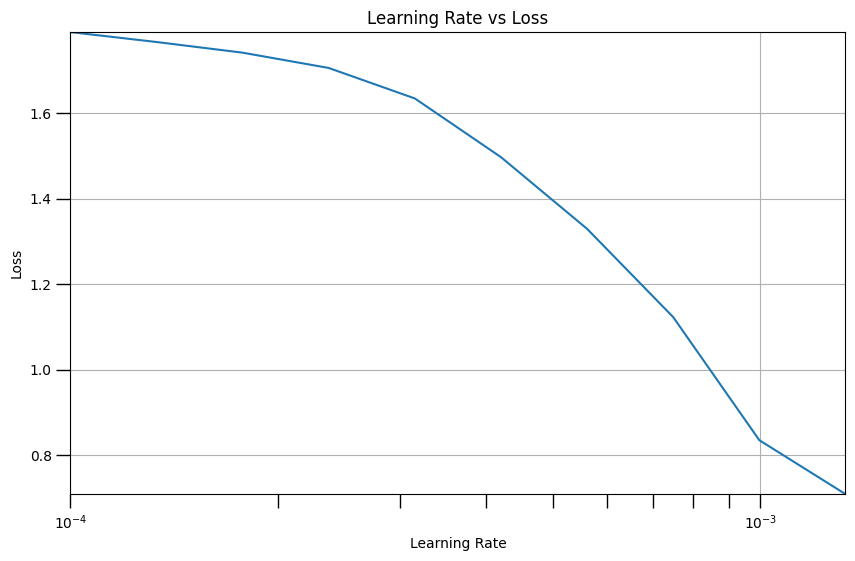

In [16]:
# Define the learning rate array
initial_lr = 1e-4
lrs = [initial_lr * (1.333 ** epoch) for epoch in range(10)]

losses = history.history['loss']

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lrs, losses)
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([min(lrs), max(lrs), min(losses), max(losses)])
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Learning Rate vs Loss')
plt.show()

# data_array = np.array([lrs, losses]).T
# print(data_array)


In [20]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model = create_model()

# Set the new learning rate
LEARNING_RATE = 0.000748 
print(f"New Learning rate: {LEARNING_RATE}")

# Set the optimizer 
optimizer = tf.keras.optimizers.SGD(learning_rate=LEARNING_RATE, momentum=0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=optimizer,
              metrics=["mae", "accuracy"])

New Learning rate: 0.000748


In [21]:
# Train the model
history = model.fit(prepared_training, 
                    epochs=25, 
                    validation_data = prepared_testing)

Epoch 1/25
230/230 [==============================] - 34s 121ms/step - loss: 1.7604 - mae: 0.2756 - accuracy: 0.3304 - val_loss: 1.7252 - val_mae: 0.2732 - val_accuracy: 0.4815
Epoch 2/25
230/230 [==============================] - 28s 122ms/step - loss: 1.6219 - mae: 0.2641 - accuracy: 0.4382 - val_loss: 1.5265 - val_mae: 0.2530 - val_accuracy: 0.4418
Epoch 3/25
230/230 [==============================] - 30s 130ms/step - loss: 1.3884 - mae: 0.2348 - accuracy: 0.4788 - val_loss: 1.3462 - val_mae: 0.2285 - val_accuracy: 0.4204
Epoch 4/25
230/230 [==============================] - 26s 113ms/step - loss: 1.1865 - mae: 0.2106 - accuracy: 0.5465 - val_loss: 1.0951 - val_mae: 0.1971 - val_accuracy: 0.5507
Epoch 5/25
230/230 [==============================] - 27s 117ms/step - loss: 0.8402 - mae: 0.1630 - accuracy: 0.6489 - val_loss: 0.8374 - val_mae: 0.1579 - val_accuracy: 0.6254
Epoch 6/25
230/230 [==============================] - 27s 117ms/step - loss: 0.8382 - mae: 0.1552 - accuracy: 0.630

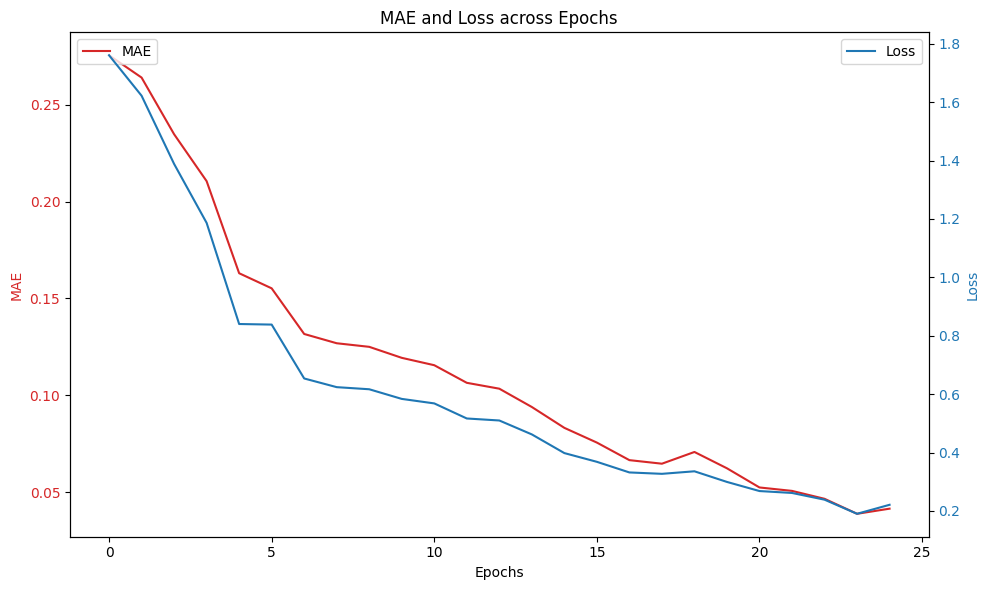

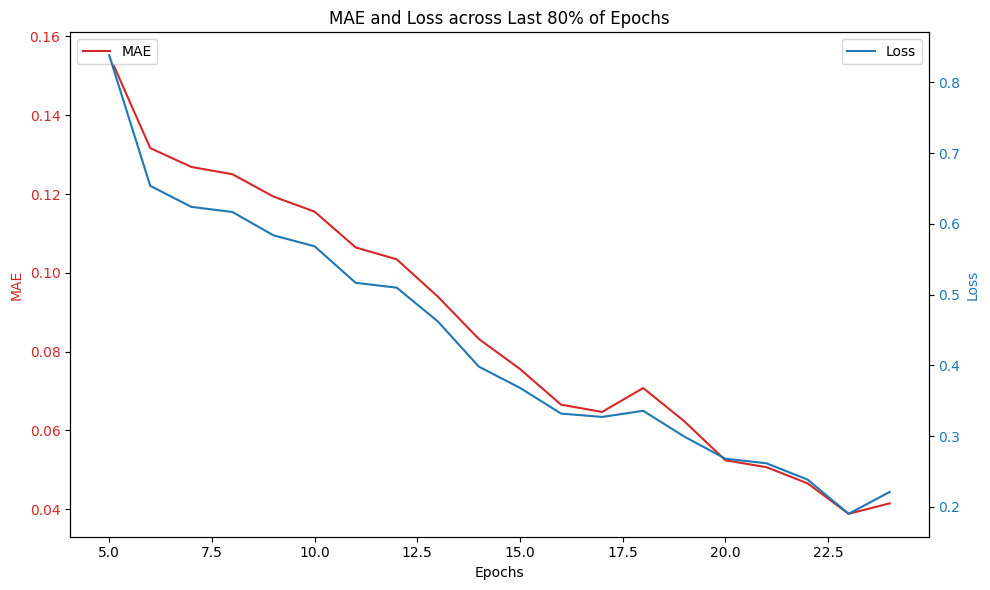

In [24]:
import matplotlib.pyplot as plt

def plot_series_dual_y(x, y1, y2, title=None, xlabel=None, ylabel1=None, ylabel2=None, legend1=None, legend2=None):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:red'
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel1, color=color)
    ax1.plot(x, y1, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel(ylabel2, color=color)
    ax2.plot(x, y2, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    if legend1 or legend2:
        ax1.legend([legend1], loc='upper left')
        ax2.legend([legend2], loc='upper right')

    plt.title(title)
    fig.tight_layout()
    plt.show()

# Get mae and loss from history log
mae = history.history['mae']
loss = history.history['loss']

# Get number of epochs
epochs = range(len(loss))

# Plotting the full graph
plot_series_dual_y(
    x=epochs, 
    y1=mae, 
    y2=loss,
    title='MAE and Loss across Epochs',
    xlabel='Epochs',
    ylabel1='MAE',
    ylabel2='Loss',
    legend1='MAE',
    legend2='Loss'
)

# Plotting the last 80% of epochs
zoom_split = int(len(epochs) * 0.2)
epochs_zoom = epochs[zoom_split:]
mae_zoom = mae[zoom_split:]
loss_zoom = loss[zoom_split:]

plot_series_dual_y(
    x=epochs_zoom, 
    y1=mae_zoom, 
    y2=loss_zoom,
    title='MAE and Loss across Last 80% of Epochs',
    xlabel='Epochs',
    ylabel1='MAE',
    ylabel2='Loss',
    legend1='MAE',
    legend2='Loss'
)


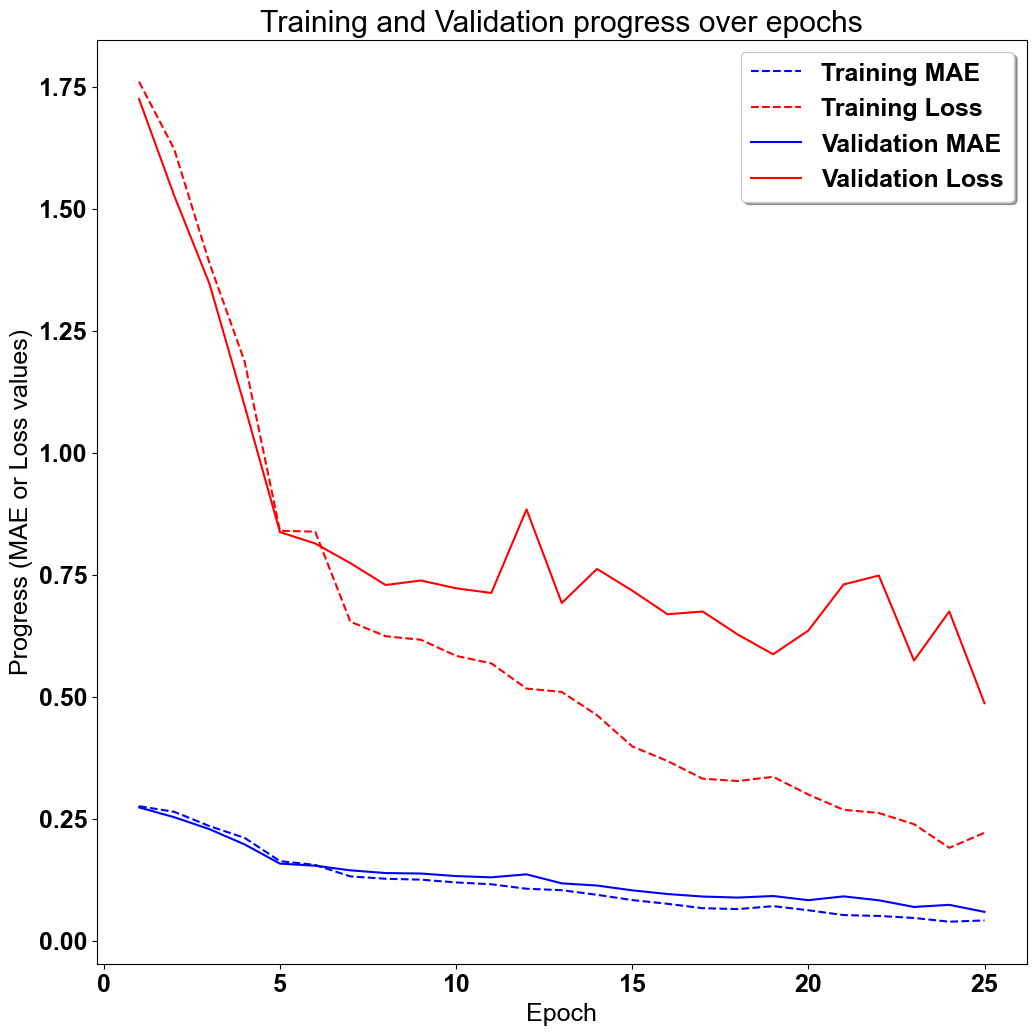

In [27]:
# Inline plots
%matplotlib inline

# Font settings
font = {
    'family': 'Arial',
    'weight': 'bold',
    'size': 18
}
plt.rc('font', **font)

# Figure size
width = 12
height = 12
plt.figure(figsize=(width, height))

# Extract training and validation metrics from history object
train_mae = history.history['mae']
train_loss = history.history['loss']
val_mae = history.history['val_mae']
val_loss = history.history['val_loss']

# Create epoch axis and plot training metrics
epochs = range(1, len(train_mae) + 1)
plt.plot(epochs, train_mae, 'b--', label='Training MAE')
plt.plot(epochs, train_loss, 'r--', label='Training Loss')

# Plot validation metrics
plt.plot(epochs, val_mae, 'b-', label='Validation MAE')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')

# Labels and title
plt.title("Training and Validation progress over epochs")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Progress (MAE or Loss values)')
plt.xlabel('Epoch')

# Show the plot
plt.show()


In [29]:
import numpy as np

# Extract the metrics from the history object
train_mae = np.array(history.history['mae'])
train_loss = np.array(history.history['loss'])
val_mae = np.array(history.history['val_mae'])
val_loss = np.array(history.history['val_loss'])

# Stack them into a 2D array
metrics_array = np.vstack([train_mae, train_loss, val_mae, val_loss])

# If you want to transpose the array so that each row corresponds to an epoch and each column to a metric, you can do:
metrics_array = metrics_array.T

print(metrics_array)

[[0.27557078 1.76043785 0.2731503  1.7252357 ]
 [0.26405042 1.62189984 0.25298023 1.5265491 ]
 [0.23479739 1.38835633 0.22848347 1.34619629]
 [0.21057406 1.18647587 0.19714656 1.09513581]
 [0.16302568 0.84015775 0.15790056 0.83736515]
 [0.1552247  0.83819813 0.15361115 0.81409037]
 [0.13165994 0.6536749  0.14412431 0.77372271]
 [0.12687148 0.62396461 0.13856298 0.72887456]
 [0.12502174 0.61674559 0.13759562 0.73816401]
 [0.11934098 0.58372808 0.13238835 0.72218865]
 [0.11553065 0.56830186 0.12979075 0.71265686]
 [0.10644317 0.51667821 0.13596009 0.88386393]
 [0.1034115  0.50981283 0.11741778 0.69209653]
 [0.0939573  0.46213377 0.11297448 0.7618919 ]
 [0.08318887 0.39818552 0.10313183 0.71748084]
 [0.07558183 0.36826903 0.09558304 0.66898233]
 [0.06651649 0.33191445 0.09041823 0.67459983]
 [0.0646811  0.32714745 0.08832493 0.62721074]
 [0.070737   0.33582619 0.09151039 0.58702433]
 [0.06230543 0.29940289 0.0829803  0.63558626]
 [0.0524086  0.26818103 0.09077867 0.73001105]
 [0.05064295 

In [30]:
predictions_prob = model.predict(prepared_testing)
predictions = np.argmax(predictions_prob, axis=1)

93/93 [==============================] - 7s 44ms/step


Testing Accuracy: 14.896504920257888%
Precision: 15.0318662014237%
Recall: 14.896504920257888%
F1 Score: 14.932293449879985%


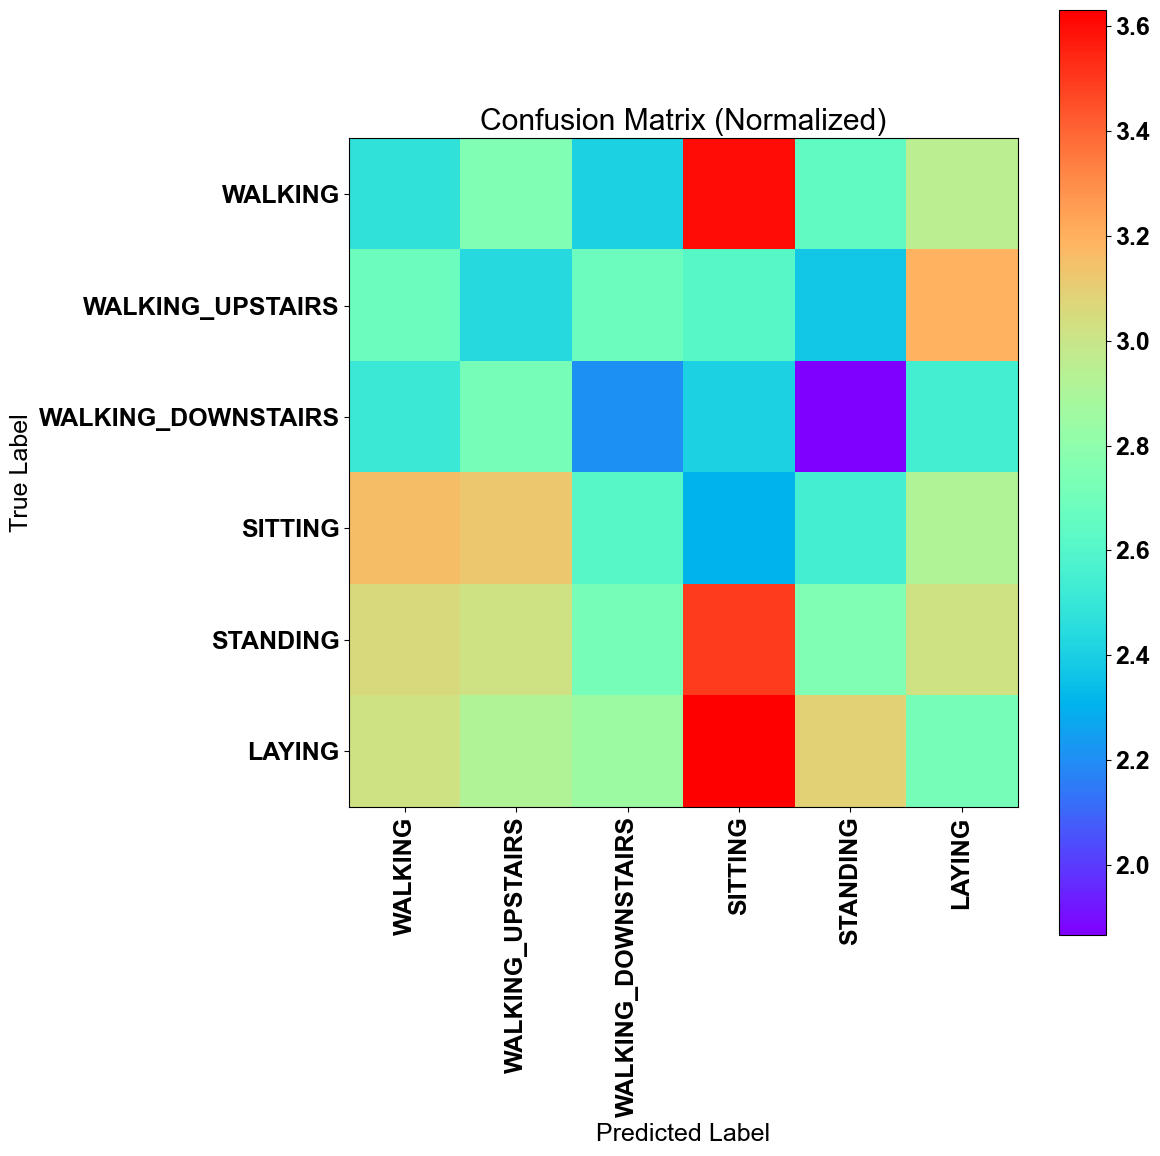

In [38]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a one-hot encoded y_test and your predictions
# Converting one-hot encoded y_test to label encoded
true_labels = np.argmax(y_test_oh, axis=1)

# Calculating accuracy
accuracy = accuracy_score(true_labels, predictions)

# Calculating other metrics
precision = precision_score(true_labels, predictions, average="weighted")
recall = recall_score(true_labels, predictions, average="weighted")
f1 = f1_score(true_labels, predictions, average="weighted")

print(f"Testing Accuracy: {accuracy * 100}%")
print(f"Precision: {precision * 100}%")
print(f"Recall: {recall * 100}%")
print(f"F1 Score: {f1 * 100}%")

# Generate confusion matrix
confusion_mtx = confusion_matrix(true_labels, predictions)
normalised_confusion_matrix = np.array(confusion_mtx, dtype=np.float32)/np.sum(confusion_mtx)*100

# LABELS you defined earlier
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
]

# Create a plot
plt.figure(figsize=(12, 12))
plt.imshow(normalised_confusion_matrix, interpolation='nearest', cmap=plt.cm.rainbow)
plt.title("Confusion Matrix (Normalized)")
plt.colorbar()

tick_marks = np.arange(len(LABELS))
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


# The Original Author's Old Model

## Additionnal Parameters:

Here are some core parameter definitions for the training. 

For example, the whole neural network's structure could be summarised by enumerating those parameters and the fact that two LSTM are used one on top of another (stacked) output-to-input as hidden layers through time steps. 

In [ ]:
# Input Data 

training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
test_data_count = len(X_test)  # 2947 testing series
n_steps = len(X_train[0])  # 128 timesteps per series
n_input = len(X_train[0][0])  # 9 input parameters per timestep


# LSTM Neural Network's internal structure

n_hidden = 32 # Hidden layer num of features
n_classes = 6 # Total classes (should go up, or should go down)


# Training 

learning_rate = 0.0025
lambda_loss_amount = 0.0015
training_iters = training_data_count * 300  # Loop 300 times on the dataset
batch_size = 1500
display_iter = 30000  # To show test set accuracy during training


# Some debugging info

print("Some useful info to get an insight on dataset's shape and normalisation:")
print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_test.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("The dataset is therefore properly normalised, as expected, but not yet one-hot encoded.")


## Utility functions for training:

In [ ]:
def LSTM_RNN(_X, _weights, _biases):
    # Function returns a tensorflow LSTM (RNN) artificial neural network from given parameters. 
    # Moreover, two LSTM cells are stacked which adds deepness to the neural network. 
    # Note, some code of this notebook is inspired from an slightly different 
    # RNN architecture used on another dataset, some of the credits goes to 
    # "aymericdamien" under the MIT license.

    # (NOTE: This step could be greatly optimised by shaping the dataset once
    # input shape: (batch_size, n_steps, n_input)
    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    # Reshape to prepare input to hidden activation
    _X = tf.reshape(_X, [-1, n_input]) 
    # new shape: (n_steps*batch_size, n_input)
    
    # ReLU activation, thanks to Yu Zhao for adding this improvement here:
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 
    # new shape: n_steps * (batch_size, n_hidden)

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # Get last time step's output feature for a "many-to-one" style classifier, 
    # as in the image describing RNNs at the top of this page
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_, n_classes=n_classes):
    # Function to encode neural one-hot output labels from number indexes 
    # e.g.: 
    # one_hot(y_=[[5], [0], [3]], n_classes=6):
    #     return [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    return np.eye(n_classes)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


## Let's get serious and build the neural network:

In [ ]:

# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random_normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out': tf.Variable(tf.random_normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


## Hooray, now train the neural network:

In [ ]:
# To keep track of training's performance
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []

# Launch the graph
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of example data at each loop
step = 1
while step * batch_size <= training_iters:
    batch_xs =         extract_batch_size(X_train, step, batch_size)
    batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Training iter #" + str(step*batch_size) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET: " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))


## Training is good, but having visual insight is even better:

Okay, let's plot this simply in the notebook for now.

In [ ]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)

width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
plt.plot(indep_test_axis, np.array(test_losses),     "b-", label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "g-", label="Test accuracies")

plt.title("Training session's progress over iterations")
plt.legend(loc='upper right', shadow=True)
plt.ylabel('Training Progress (Loss or Accuracy values)')
plt.xlabel('Training iteration')

plt.show()

## And finally, the multi-class confusion matrix and metrics!

In [ ]:
# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
confusion_matrix = metrics.confusion_matrix(y_test, predictions)
print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

print("")
print("Confusion matrix (normalised to % of total test data):")
print(normalised_confusion_matrix)
print("Note: training and testing data is not equally distributed amongst classes, ")
print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.rainbow
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
sess.close()

## Conclusion

Outstandingly, **the final accuracy is of 91%**! And it can peak to values such as 93.25%, at some moments of luck during the training, depending on how the neural network's weights got initialized at the start of the training, randomly. 

This means that the neural networks is almost always able to correctly identify the movement type! Remember, the phone is attached on the waist and each series to classify has just a 128 sample window of two internal sensors (a.k.a. 2.56 seconds at 50 FPS), so it amazes me how those predictions are extremely accurate given this small window of context and raw data. I've validated and re-validated that there is no important bug, and the community used and tried this code a lot. (Note: be sure to report something in the issue tab if you find bugs, otherwise [Quora](https://www.quora.com/), [StackOverflow](https://stackoverflow.com/questions/tagged/tensorflow?sort=votes&pageSize=50), and other [StackExchange](https://stackexchange.com/sites#science) sites are the places for asking questions.)

I specially did not expect such good results for guessing between the labels "SITTING" and "STANDING". Those are seemingly almost the same thing from the point of view of a device placed at waist level according to how the dataset was originally gathered. Thought, it is still possible to see a little cluster on the matrix between those classes, which drifts away just a bit from the identity. This is great.

It is also possible to see that there was a slight difficulty in doing the difference between "WALKING", "WALKING_UPSTAIRS" and "WALKING_DOWNSTAIRS". Obviously, those activities are quite similar in terms of movements. 

I also tried my code without the gyroscope, using only the 3D accelerometer's 6 features (and not changing the training hyperparameters), and got an accuracy of 87%. In general, gyroscopes consumes more power than accelerometers, so it is preferable to turn them off. 


## Improvements

In [another open-source repository of mine](https://github.com/guillaume-chevalier/HAR-stacked-residual-bidir-LSTMs), the accuracy is pushed up to nearly 94% using a special deep LSTM architecture which combines the concepts of bidirectional RNNs, residual connections, and stacked cells. This architecture is also tested on another similar activity dataset. It resembles the nice architecture used in "[Google’s Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/pdf/1609.08144.pdf)", without an attention mechanism, and with just the encoder part - as a "many to one" architecture instead of a "many to many" to be adapted to the Human Activity Recognition (HAR) problem. I also worked more on the problem and came up with the [LARNN](https://github.com/guillaume-chevalier/Linear-Attention-Recurrent-Neural-Network), however it's complicated for just a little gain. Thus the current, original activity recognition project is simply better to use for its outstanding simplicity. 

If you want to learn more about deep learning, I have also built a list of the learning ressources for deep learning which have revealed to be the most useful to me [here](https://github.com/guillaume-chevalier/Awesome-Deep-Learning-Resources). 


## References

The [dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) can be found on the UCI Machine Learning Repository: 

> Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

## Citation

Copyright (c) 2016 Guillaume Chevalier. To cite my code, you can point to the URL of the GitHub repository, for example: 

> Guillaume Chevalier, LSTMs for Human Activity Recognition, 2016, 
> https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

My code is available for free and even for private usage for anyone under the [MIT License](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/blob/master/LICENSE), however I ask to cite for using the code. 

Here is the BibTeX citation code: 
```
@misc{chevalier2016lstms,
  title={LSTMs for human activity recognition},
  author={Chevalier, Guillaume},
  year={2016}
}
```

## Extra links

### Connect with me

- [LinkedIn](https://ca.linkedin.com/in/chevalierg)
- [Twitter](https://twitter.com/guillaume_che)
- [GitHub](https://github.com/guillaume-chevalier/)
- [Quora](https://www.quora.com/profile/Guillaume-Chevalier-2)
- [YouTube](https://www.youtube.com/c/GuillaumeChevalier)
- [Dev/Consulting](http://www.neuraxio.com/en/)

### Liked this project? Did it help you? Leave a [star](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/stargazers), [fork](https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition/network/members) and share the love!

This activity recognition project has been seen in:

- [Hacker News 1st page](https://news.ycombinator.com/item?id=13049143)
- [Awesome TensorFlow](https://github.com/jtoy/awesome-tensorflow#tutorials)
- [TensorFlow World](https://github.com/astorfi/TensorFlow-World#some-useful-tutorials)
- And more.

---


In [ ]:
# Let's convert this notebook to a README automatically for the GitHub project's title page:
!jupyter nbconvert --to markdown LSTM.ipynb
!mv LSTM.md README.md